## 1-D Black and Scholes


In [18]:
import numpy as np
import scipy.sparse as sp
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import solve
import sys, time
import scipy.linalg
import scipy.sparse.linalg



In [27]:
def mass(N,h):
    return h * sp.diags([1/6, 4/6, 1/6], [-1,0,1], shape = [N,N], format = 'csr')   
            
def Af(xmax,h): # diffusion
    N = int(xmax/h)
    Af_ = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            if abs(i-j) > 1:
                Af_[i,j] = 0.
            elif i==j:
                Af_[i,j] = h/600*(6*i**2+2)
            else:
                idx = max(i,j)
                Af_[i,j] = -h/600*(3*idx**2+3*idx+1)
    return Af_
                
def Ad(xmax,h): # advection
    N = int(xmax/h)
    Ad_ = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            if abs(i-j)>1:
                Ad_[i,j] = 0
            elif i==j:
                Ad_[i,j] = -0.04*(2*i**2+2)*h/6
            elif i<j:
                Ad_[i,j] = -0.04 * (i**2+3*i+1) * h/6
            else:
                Ad_[i,j] = -0.04 * (i**2-3*i+1)*h/6
    return Ad_

def Ar(xmax,h): # reaction (essentially same as mass)
    N = int(xmax)
    return 0.05 * mass(N,h)

def A(N,h):
    return Ad(N,h) + Af(N,h) + Ar(N,h)

def u0(xmax,h):
    N = int(xmax/h)
    u0_ = np.zeros((N))
    E = 30
    for i in range(N):
        u0_[i] = max(E-(i+1)*h,0)
    return u0_

def U(xmax, h, theta, dt, Tf):
    N = int(xmax/h)
    M = mass(N,h)
    A_ = A(N,h)
    u0_ = u0(xmax,h)
    n = int(Tf/dt)
    U = np.zeros((N,n+1))
    U[:,0] = u0_
    for i in range(n):
        leftMat = M+dt*theta*A_
        rightMat = M-dt*(1-theta)*A_
        un = rightMat*U[:,i].reshape(N,1)
        ut = solve(leftMat, un)
        U[:,i+1] = ut.reshape(N,)
    return U

In [28]:
## define problem
xmax = 100
h = 1
Tf = 1
dt = 0.01
theta = 0.5
U = U(xmax, h, theta, dt, Tf)


0.0


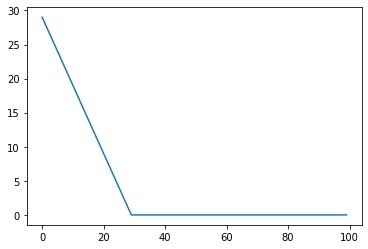

In [46]:
# pd.DataFrame(U)
plt.plot(U[:,0])
print(U[32,0])


## 2-D Black & Scholes

In [ ]:
# 1D Black & Scholes
"""
MATH572 Parabolic Problems

@author: Alessandro
"""

def IC(x,E):
# initial conditions
    N = x.size
    v = np.zeros(N)
    for i in range(0,N):
        v[i] = max(x[i]-E,0.) # call
        #v[i] = max(E-x[i],0.) # put
        
    return v
#    return np.sin(np.pi*x)

def BC(a,b,t,E,r):
    uL = 0. # call
    uR = b - E*np.exp(-r*t) # call
    #uL = E*np.exp(-r*t)  # put
    #uR = 0. # put
    return uL, uR

def f(x,t):
    return 0.0


# DEFINITION OF THE PROBLEM
T = 1. # final time
xl = 0. # leftmost point
xr = 100. # righmost point (xM)

sigma = 0.1 # volatility
r = 0.05
E = 30.


# discretization parameters
dt = 0.01
h = 1.
th = 1. # theta

Nx = int(round(np.abs(xr-xl)/h))
Nt = int(round(T/dt))

# Space mesh & time mesh
x = np.linspace(xl,xr,Nx+1)
t = np.linspace(0,T,Nt+1)

# Error computing data structures
eil = np.zeros(Nt)
el2l = np.zeros(Nt)


# MATRIX ASSEMBLY (for time independent coefficients)
u   = np.zeros(Nx+1)
u_n = np.zeros(Nx+1)


# Data structures for the linear system
A = np.zeros((Nx+1, Nx+1))
b = np.zeros(Nx+1)

Ad =sp.diags([1., -2., 1.], [-1, 0, 1], shape=[Nx+1, Nx+1], format = 'csr') #basic discretization
Ac =sp.diags([-1., 0., 1.], [-1, 0, 1], shape=[Nx+1, Nx+1], format = 'csr') #basic discretization
Ar = r*sp.identity(Nx+1, format = 'csr')

print(Ad)

for i in range(1,Nx):
    for j in range(i-1,i+2):
        print(i,j)
        Ad[i,j] = -0.5*(sigma**2)*(x[i]**2)/h**2*Ad[i,j]
        Ac[i,j] = -r*x[i]/(2*h)*Ac[i,j]

Ad[0, 0] = -0.5*(sigma**2)*x[0]**2/h**2*Ad[0,0]
Ad[0, 1] = -0.5*(sigma**2)*x[0]**2/h**2*Ad[0,1]
Ad[-1,-2] = -0.5*(sigma**2)*x[-1]**2/h**2*Ad[-1,-2]
Ad[-1,-1] = -0.5*(sigma**2)*x[-1]**2/h**2*Ad[-1,-1]

print(Ad)

Ac[0, 0] =  -r*x[0]/(2*h)*Ac[0,0]
Ac[0, 1] =  -r*x[0]/(2*h)*Ac[0,1]
Ac[-1,-2] = -r*x[-1]/(2*h)*Ac[-1,-2]
Ac[-1,-1] = -r*x[-1]/(2*h)*Ac[-1,-1]


A = Ad + Ac + Ar

LeftM = sp.identity(Nx+1, format = 'csr') + dt*th*A
RightM = sp.identity(Nx+1, format = 'csr') - dt*(1-th)*A

# boundary conditions
aux_bc = 1.
LeftM[0, 1] = 0.
LeftM[-1, -2] = 0.
LeftM[0, 0] = aux_bc
LeftM[-1, -1] = aux_bc


# REM: We could factorize the matrix LeftM here

# Initial conditions
tc = 0 # current time
u_n = IC(x, E)
# visualize(x,tc,u_n)

# TIME LOOP
for n in range(0,Nt):
    tc += dt
    print("Computing at time", tc)
    # right hand side
    b = dt*(th*f(x,tc)+(1-th)*f(x,tc-dt)) + RightM*u_n
    uL, uR = BC(xl,xr,tc, E, r)
    b[0] = aux_bc*uL
    b[-1] = aux_bc*uR
    u = sp.linalg.spsolve(LeftM, b)
#     print(u)
#     visualize(x,tc,u)
    u_n = u



In [26]:
# build matrix A
def buildA(spaceMax, h):
    sigma1 = 0.1
    sigma2 = 0.3
    rho = 0.5
    r = 0.1
    N = int(spaceMax/h)+1
    A = np.zeros((N*N,N*N)) # size (N-1) * (N-1)
    
    for j in range(N): # adjust boundary coefficients
        A[j,j] = 1
        A[-j,-j] = 1
        A[j*N, j*N] = 1
        A[(j+1)*(N-1), (j+1)*(N-1)] = 1
        
    for i in range(1,N-1):
        xi = i*h
        for j in range(1,N-1):
            yj = j*h
            A[i*N+j, i*N+j] = sigma1**2 * xi**2 / h**2 + sigma2**2 * yj**2 / h**2 +r  #V_{i}{j}
            A[i*N+j, i*N+j-1] = -0.5 * (sigma2 * yj / h)**2 + r*yj/(2*h)  #V_{i}{j-1}
            A[i*N+j, i*N+j+1] = -0.5 * (sigma2 * yj / h)**2 - r*yj/(2*h)  #V_{i}{j+1}
            A[i*N+j, (i+1)*N + j] = -0.5 * (sigma1 * xi / h)**2 - r*xi/(2*h)  #V_{i+1}{j}
            A[i*N+j, (i+1)*N + j-1] = rho*sigma1*sigma2*xi*yj/(4*h**2)  #V_{i+1}{j-1}
            A[i*N+j, (i+1)*N + j+1] = -rho*sigma1*sigma2*xi*yj/(4*h**2) #V_{i+1}{j+1}
            A[i*N+j, (i-1)*N + j] = -0.5 * (sigma1 * xi / h)**2 + r*xi/(2*h)  #V_{i-1}{j}
            A[i*N+j, (i-1)*N + j-1] = -rho*sigma1*sigma2*xi*yj/(4*h**2)  #V_{i-1}{j-1}
            A[i*N+j, (i-1)*N + j+1] = rho*sigma1*sigma2*xi*yj/(4*h**2)  #V_{i-1}{j+1}
    
    return A



def V_0y(j,t,h):
    return gy(j*h,t) # boundary condition

    
def V_x0(i,t,h):
    return gx(i*h,t) # boundary condition

def vec(t,spaceMax,h): # this is the vector generated naturally in the system due to adjustment of boundary contitions
    N = int(spaceMax/h)+1
    b = np.zeros((N*N,1))
    for j in range(N):
        b[j] = V_0y(j,t,h)
        b[-j] = 0. # for the sake of completeness
    for i in range(N):
        b[i*N] = V_x0(i,t,h)
        b[(i+1)*(N-1)] = 0 # for the sake of completeness
    
    return b

# IC
def IC(x,y):
    E=30
    return max(0, E-(x+y))

def V_t0(spaceMax, h):
    N = int(spaceMax/h)+1
    v0 = np.zeros((N*N,1))
    for i in range(N):
        xi = i*h
        for j in range(N):
            yi = j*h
            v0[i*N+j] = IC(xi,yj)
    
    return v0
    
def fullDiscretization(Tf, dt, theta, spaceMax, h):
    N = int(spaceMax/h)+1 # number of space nodes
    n = int(Tf/dt) # number of time nodes
    A = buildA(spaceMax,h) # coefficient matrix
    v0 = V_t0(spaceMax,h) # initial condition
    V = v0 
    I = np.identity(N**2) # identity matrix of size N^2
    leftMat = I + dt*theta*A
    rightMat = I - dt*(1-theta)*A
    for i in range(n): # loop over time
        ti = (i+1)*dt
        rightVec = vec(ti,spaceMax,h)
        vn = V[:,i]
        RHS = np.dot(rightMax,vn) + rightVec
        vt = solve(leftMat, RHS)
        V = np.append(V, vt, axis=1)
    
    return V
    

In [16]:
# define problem
spaceMax = 100
h = 1
A = buildA(spaceMax, h)

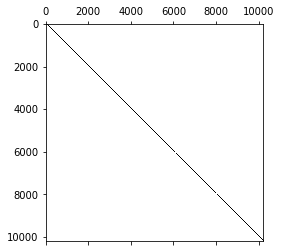

In [17]:
plt.spy(A)

In [23]:
print(np.zeros((10,1))[4])

[0.]
